<a href="https://colab.research.google.com/github/AlexeyTri/Yolo8-app/blob/main/FIRST_APP/YOLO8_changed_indexes_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install ultralytics==8.0.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

import json
import os
import shutil
from tqdm import tqdm
from pprint import pprint
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image 
from ultralytics import YOLO
from IPython.display import display, Image

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.6/107.7 GB disk)


Подключаем ЯНДЕКС-диск и загружаем БД с фотографиями

In [5]:
!wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
!chmod +x ya.py
!./ya.py https://disk.yandex.ru/d/Rx6PNLfOakcttw /content/dataset

--2023-03-05 06:40:49--  https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 723 [text/plain]
Saving to: ‘ya.py’

ya.py               100%[===================>]     723  --.-KB/s    in 0s      

2023-03-05 06:40:49 (37.6 MB/s) - ‘ya.py’ saved [723/723]

--2023-03-05 06:40:51--  https://downloader.disk.yandex.ru/zip/370a1ed4542a893de988ad5c483d31b70ed34e11e71c8769e897b8d8dfc848a6/640439eb/RWxIWm1OS1hGaGh4TlRUdjM0MXYxWWhvUnF0K1RseU5rTHRubGdXQ0gzM3lsWVAxa2FRQlRUZFJveklLa0ZLcUc3cFdwVlFZc3VieXJjYWpIaW1QRnc9PTo=?uid=0&filename=%D0%94%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D1%8B.zip&disposition=attachment&hash=ElHZmNKXFhhxNTTv341v1YhoRqt%2BTly

In [6]:
!unzip Датасеты.zip -d datasets

Archive:  Датасеты.zip
  inflating: datasets/Датасеты/Персонал/dataset/annotation_data.json  
  inflating: datasets/Датасеты/Персонал/dataset/coco_categories.json  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_1/_1_000250.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_1/_1_002450.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_001875.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_004000.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_014700.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_016525.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_018250.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_019350.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2020-10-16/_10/_10_019500.jpg  
  inflating: datasets/Датасеты/Персонал/dataset/images/2

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
with open('/content/datasets/Датасеты/Персонал/dataset/annotation_data.json') as annotations_file:
    annotations_js = json.load(annotations_file)
    print('Annotations')
    print(annotations_js.keys())
    
with open('/content/datasets/Датасеты/Персонал/dataset/coco_categories.json') as coco_categories_file:
    coco_categories_js = json.load(coco_categories_file)
    print('Coco categories')
    print(coco_categories_js.keys())
    pprint(coco_categories_js['categories'])

Annotations
dict_keys(['categories', 'annotations', 'images', 'licenses'])
Coco categories
dict_keys(['categories'])
[{'color': [0, 255, 0],
  'exclude': False,
  'id': 3,
  'is_primary': True,
  'is_violation': False,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'person',
  'ru_name': 'Человек',
  'supercategory': 'person',
  'threshold': 0.7},
 {'color': [0, 127, 0],
  'exclude': False,
  'id': 10,
  'is_primary': True,
  'is_violation': False,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'person_nik',
  'ru_name': 'Персонал НИК',
  'supercategory': 'person',
  'threshold': 0.7},
 {'color': [0, 255, 0],
  'exclude': False,
  'id': 4,
  'is_primary': False,
  'is_violation': False,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'vest',
  'ru_name': 'Жилет',
  'supercategory': 'vest',
  'threshold': 0.7},
 {'color': [0, 0, 255],
  'exclude': False,
  'id': 5,
  'is_primary': False,
  'is_violation': True,
  'keypoints': [],
  'keypoints_style': [],
  'name': 'v

In [9]:
categories_dict = dict()
categories_indexes_dict = dict()
for i, category in enumerate(annotations_js['categories']):
    categories_indexes_dict[category['id']] = i
    categories_dict[i] = category['name']
print(categories_indexes_dict, categories_dict)

{3: 0, 10: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 11: 8} {0: 'person', 1: 'person_nik', 2: 'vest', 3: 'vest_viol', 4: 'helmet', 5: 'helmet_viol', 6: 'welding_mask', 7: 'head_hood', 8: 'head_unknown'}


In [10]:
for filename in os.scandir('/content/datasets/Датасеты/Персонал/dataset/images'):
    print(filename, end=" ")

<DirEntry '2020-10-16'> <DirEntry '2020-10-20_2'> <DirEntry '2020-10-20_3'> <DirEntry '2020-10-17'> <DirEntry '2020-10-20_1'> <DirEntry '2020-10-28'> 

In [11]:
images_dict = dict()
for image in annotations_js['images']:
    images_dict[image['id']] = image['file_name']
print(images_dict[1000000])

NIK_2020-10-28/1_3_2020_10_26-06_28_12.701.jpg


In [12]:
annotations_df = []
for annotation in tqdm(annotations_js['annotations']):
    category_id_raw = annotation['category_id']
    category_id_for_yolo = categories_indexes_dict[category_id_raw]
    tmp = {
        'image_id': annotation['image_id'],
        'image_path': images_dict[annotation['image_id']],
        'category_id': category_id_for_yolo,
        'category_name': categories_dict[category_id_for_yolo],
        'bbox': list(map(lambda x: round(x, 2), annotation['bbox'])),
        'area': annotation['area']
    }
    annotations_df.append(tmp)

annotations_df = pd.DataFrame(annotations_df)
annotations_df

100%|██████████| 21275/21275 [00:00<00:00, 180408.10it/s]


image_id                                      image_path  category_id  \
0       1001854  NIK_2020-10-28/1_2_2020_10_26-05_55_44.068.jpg            0   
1       1001854  NIK_2020-10-28/1_2_2020_10_26-05_55_44.068.jpg            0   
2       1001854  NIK_2020-10-28/1_2_2020_10_26-05_55_44.068.jpg            3   
3       1001854  NIK_2020-10-28/1_2_2020_10_26-05_55_44.068.jpg            3   
4       1001854  NIK_2020-10-28/1_2_2020_10_26-05_55_44.068.jpg            3   
...         ...                                             ...          ...   
21270   1002696  NIK_2020-10-28/1_2_2020_10_27-06_07_15.892.jpg            0   
21271   1002696  NIK_2020-10-28/1_2_2020_10_27-06_07_15.892.jpg            0   
21272   1002696  NIK_2020-10-28/1_2_2020_10_27-06_07_15.892.jpg            3   
21273   1002696  NIK_2020-10-28/1_2_2020_10_27-06_07_15.892.jpg            4   
21274   1002696  NIK_2020-10-28/1_2_2020_10_27-06_07_15.892.jpg            3   

      category_name                             bbox         area  
0            person  [1595.49, 568.37, 13.11, 47.61]   624.314932  
1            person  [1489.89, 591.29, 16.63, 61.03]  1014.817959  
2         vest_viol  [1458.86, 599.18, 19.71, 29.66]   584.669388  
3         vest_viol  [1490.23, 600.38, 14.91, 25.03]   373.283265  
4         vest_viol   [1595.31, 573.81, 13.2, 26.06]   343.954286  
...             ...                              ...          ...  
21270        person  [1423.91, 866.15, 59.01, 76.71] -4526.252845  
21271        person   [1352.8, 818.01, 56.21, 76.09] -4276.937618  
21272     vest_viol   [1368.63, 818.94, 35.09, 32.3] -1133.443926  
21273        helmet  [1372.05, 831.99, 18.32, 19.57]   358.493114  
21274     vest_viol  [1432.92, 866.77, 47.83, 26.71]  1277.342695  

[21275 rows x 6 columns]

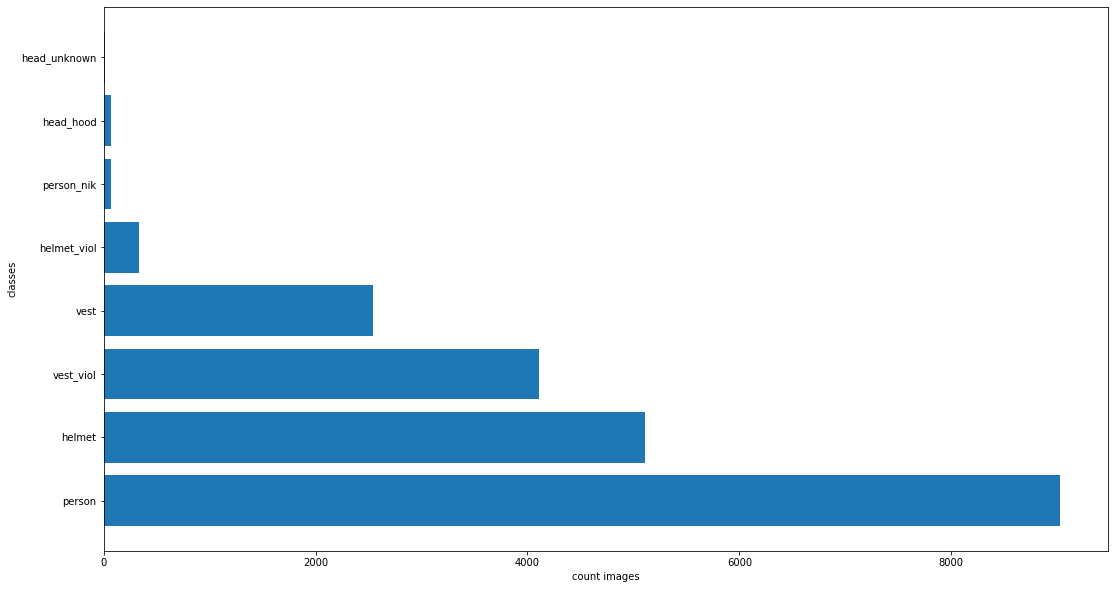

In [13]:
vc = annotations_df['category_name'].value_counts()

plt.figure(figsize=(18,10))
plt.barh(vc.index, vc.values)
plt.ylabel('classes')
plt.xlabel('count images')
plt.show()

In [14]:
model = YOLO('yolov8n.yaml')
results = model.predict(source='/content/datasets/Датасеты/Персонал/dataset/images/2020-10-20_3/1_3_2020_10_24-05_03_58.083.jpg',save='/content/my/detect/predict/', verbose=True)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [17]:
from PIL import Image

In [18]:
img = Image.open('/content/runs/detect/predict/1_3_2020_10_24-05_03_58.083.jpg')

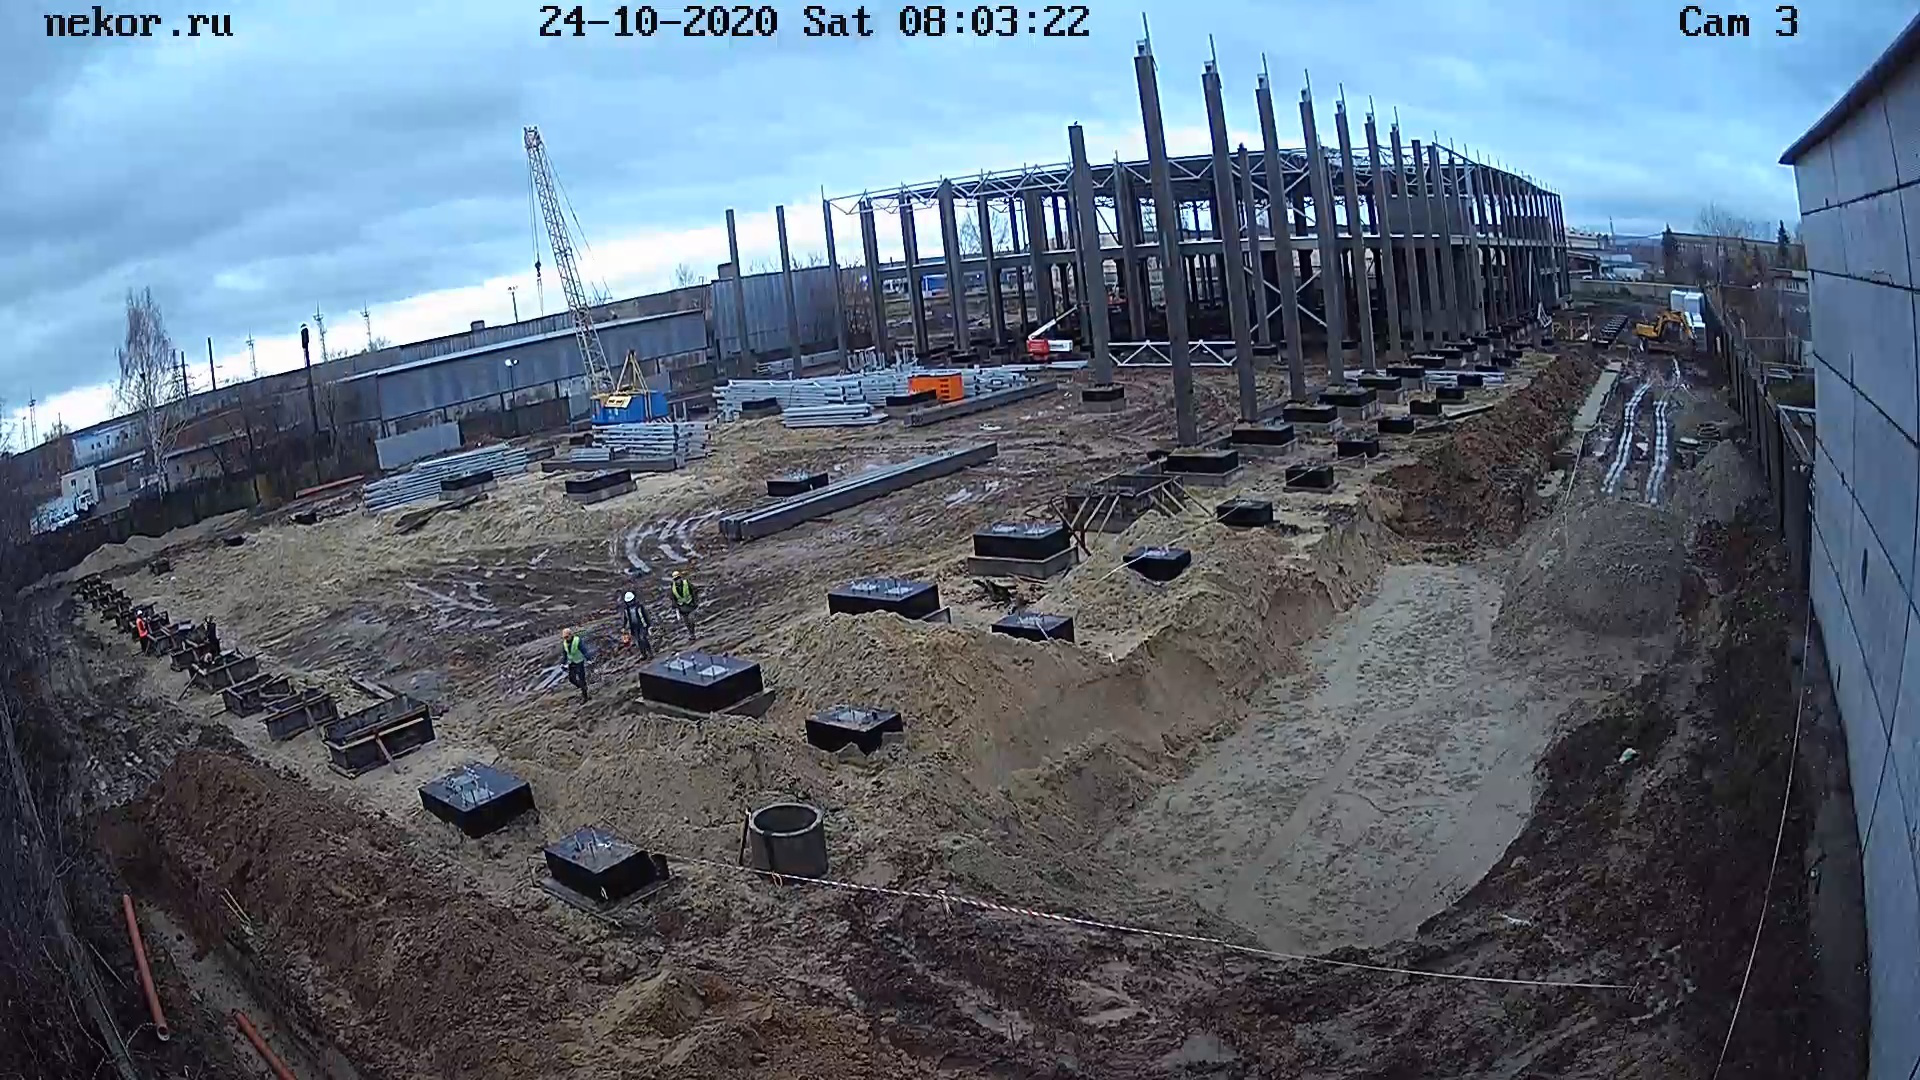

In [19]:
img

In [20]:
def image_description_yolo8(image_data: pd.DataFrame, path: str = '/content/datasets/Датасеты/Персонал/dataset/images') -> np.array:
    image_id = image_data['image_id'].values[0]
    image_path = image_data['image_path'].values[0][4:]
    img = cv2.cvtColor(
        cv2.imread(os.path.join(path, image_path)),
        cv2.COLOR_BGR2RGB
    )
    img_height, img_width, _ = img.shape
    result_description = []
    
    for idx, row in image_data.iterrows():
        category_id = row['category_id']
        bbox = row['bbox']
        x1, y1, obj_width, obj_height = tuple(bbox)
        x_center = x1 + (obj_width / 2)
        y_center = y1 + (obj_height / 2)
        x_center /= img_width
        obj_width /= img_width
        y_center /= img_height
        obj_height /= img_height
        desc = {
            'category_id': category_id,
            'x_center': x_center,
            'y_center': y_center,
            'bbox_width': obj_width,
            'bbox_height': obj_height
        }
        result_description.append(desc)
        
    return pd.DataFrame(result_description)


def prepare_folders_2():
    if not os.path.exists('yolo_model_dataset_2'):
        os.makedirs('yolo_model_dataset_2')
    
    os.makedirs('./yolo_model_dataset_2/train/images')
    os.makedirs('./yolo_model_dataset_2/train/labels')
    
    os.makedirs('./yolo_model_dataset_2/val/images')
    os.makedirs('./yolo_model_dataset_2/val/labels')
    
    
def split_images(annotations_df: pd.DataFrame, test_size: float = 0.2, random_state = 5) -> pd.DataFrame:
    images_to_split = annotations_df['image_id'].unique()

    images_train, images_val = train_test_split(images_to_split, test_size=test_size, random_state=5)

    train_images = pd.Series(index=images_train, data=1)
    val_images = pd.Series(index=images_val, data=0)

    images_splitted = pd.concat([train_images, val_images])

    annotations_df['is_train'] = annotations_df['image_id'].map(images_splitted)
    return annotations_df

    
def copy_images2(annotations_df: pd.DataFrame, test_size: float = 0.2, images_path: str = '/content/datasets/Датасеты/Персонал/dataset/images'):
    
    if 'is_train' not in annotations_df.columns:
        annotations_df = split_images(annotations_df)
    
    for image_id in tqdm(annotations_df['image_id'].unique()):
        cur_image_data = annotations_df.loc[
            annotations_df['image_id'] == image_id
        ]
        image_path = cur_image_data['image_path'].values[0][4:]
        is_train = annotations_df[annotations_df['image_id'] == image_id]['is_train'].values[0]
        
        image_description = image_description_yolo8(cur_image_data, images_path)
        image_name = os.path.basename(image_path)
        
        if is_train:
            shutil.copy(
                os.path.join(images_path, image_path),
                os.path.join('./yolo_model_dataset_2/train/images', image_name)
            )
            image_description.to_csv(
                os.path.join('./yolo_model_dataset_2/train/labels', image_name.replace('.jpg', '.txt')),
                index=False,
                header=False,
                sep=' '
            )
            
        else:
            shutil.copy(
                os.path.join(images_path, image_path),
                os.path.join('./yolo_model_dataset_2/val/images', image_name)
            )
            image_description.to_csv(
                os.path.join('./yolo_model_dataset_2/val/labels', image_name.replace('.jpg', '.txt')),
                index=False,
                header=False,
                sep=' '
            )

In [21]:
prepare_folders_2()
copy_images2(annotations_df)

100%|██████████| 2392/2392 [02:04<00:00, 19.23it/s]


In [22]:
import yaml

custom = {'path':  '/content/yolo_model_dataset_2',
           'train': './train/images',
           'val': './val/images',
            'names': categories_dict
         }
print(custom)

# Convert Python dictionary into a YAML document
with open(r'custom.yaml', 'w') as file:
    documents = yaml.dump(custom, file)

{'path': '/content/yolo_model_dataset_2', 'train': './train/images', 'val': './val/images', 'names': {0: 'person', 1: 'person_nik', 2: 'vest', 3: 'vest_viol', 4: 'helmet', 5: 'helmet_viol', 6: 'welding_mask', 7: 'head_hood', 8: 'head_unknown'}}


In [23]:
# Use the model
results = model.train(data='custom.yaml', epochs=5)  # train the model
rsult_val = model.val(data='custom.yaml')
success = model.export(format='onnx')  # export the model to ONNX format

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CPU
yolo/engine/trainer: task=detect, mode=train, model=None, data=custom.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4, nms=False, lr0=0.01, lrf=0.01, momentum

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [48]:
model_train = YOLO('/content/runs/detect/train/weights/best.pt')

In [44]:
model.predict(source='/content/runs/detect/predict/1_3_2020_10_24-05_03_58.083.jpg', save='/content/my/detect/predict/')

Results saved to runs/detect/predict


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([0, 6])
 dtype: torch.float32
  + tensor([], size=(0, 6))]

In [54]:
img_train = Image.open('/content/runs/detect/predict2/1_3_2020_10_24-05_03_58.083.jpg')

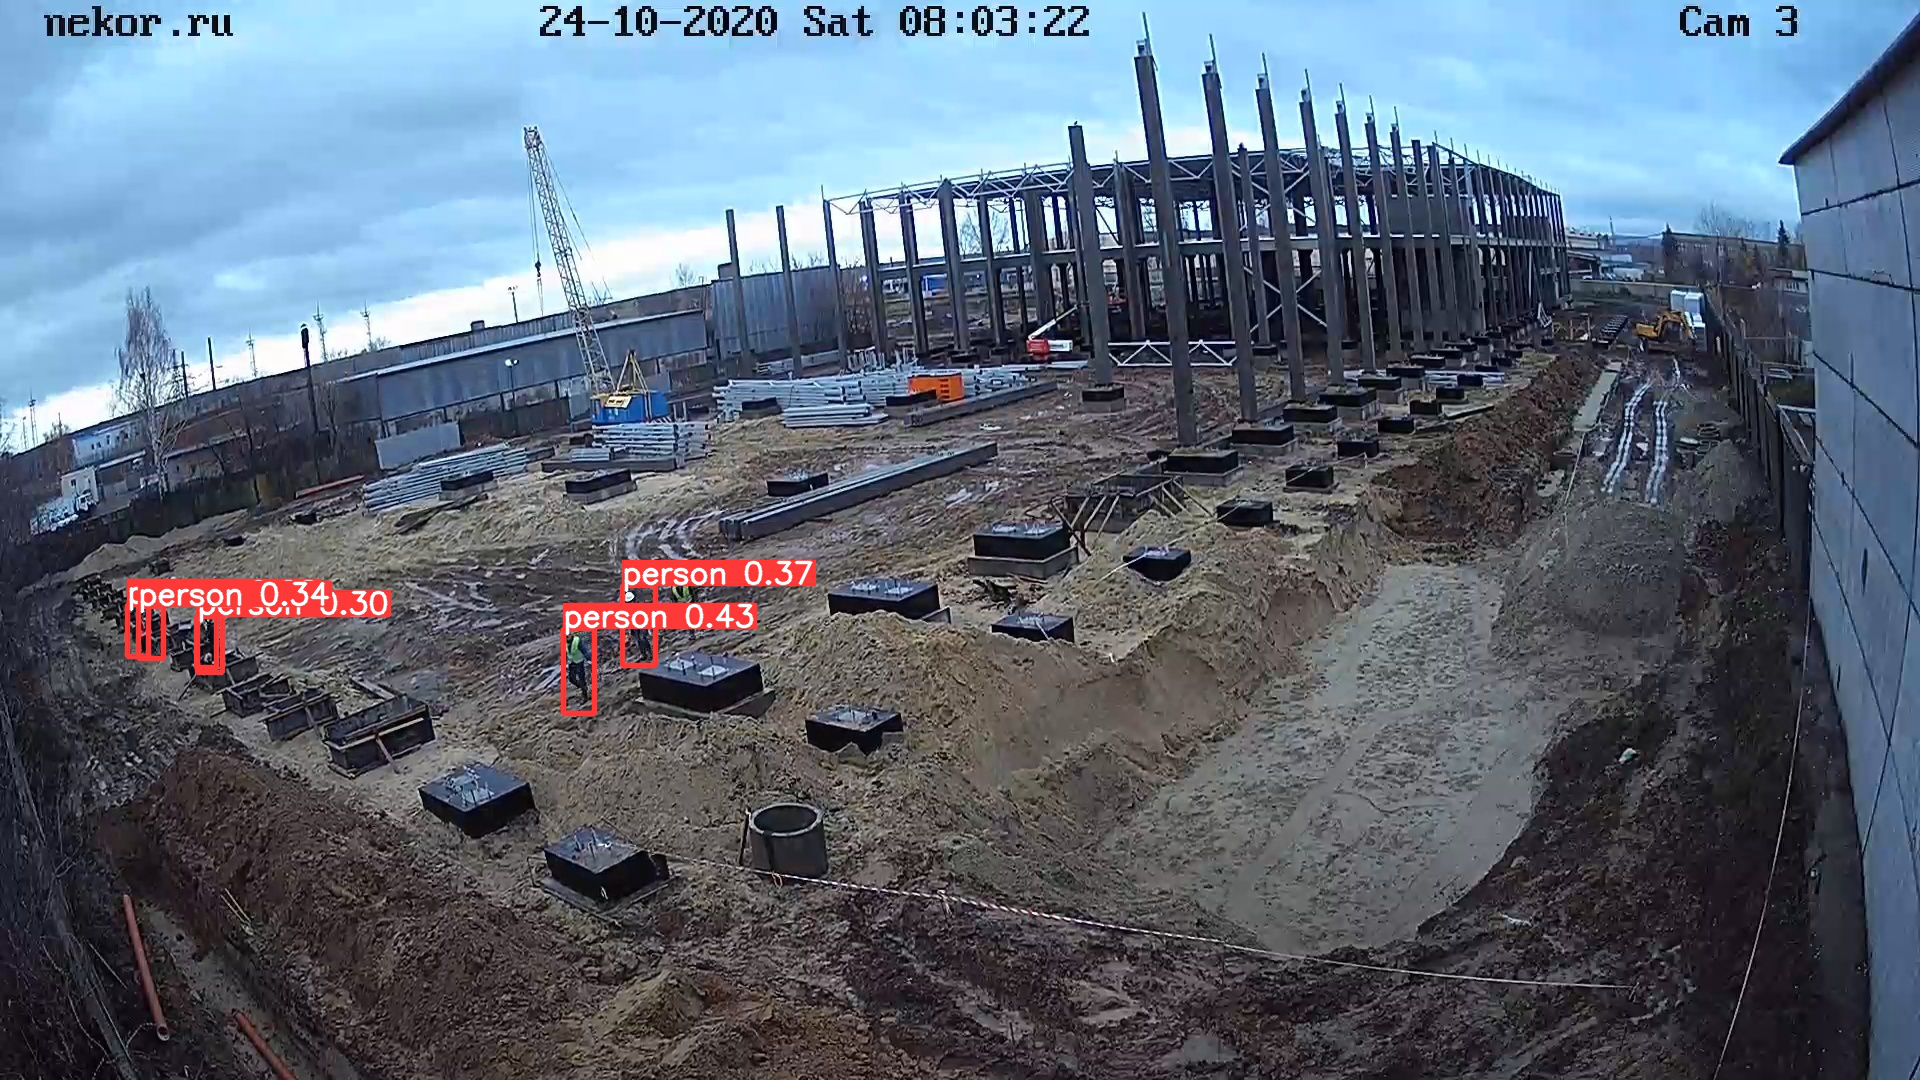

In [55]:
img_train